# Fermion

In [1]:
import quantum_simulation_recipe as qsr
from quantum_simulation_recipe import spin_ham, fermion_ham

### Jordan-Wigner transformation

## Chemical molecules

In [5]:
d = 1.0
n_hydrogen = 2
n = n_hydrogen * 2
h2 = fermion_ham.hydrogen_chain_hamiltonian(n_hydrogen, d, verbose=False)

# pstr: 15, ['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'YXXY', 'YYXX', 'XXYY', 'XYYX', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ']
# groups: 2
[[{'IIII': (-0.3276081896748102+0j)}, {'ZIII': (0.13716572937099497+0j)}, {'IZII': (0.13716572937099497+0j)}, {'IIZI': (-0.13036292057109025+0j)}, {'IIIZ': (-0.13036292057109025+0j)}, {'ZZII': (0.15660062488237947+0j)}], [{'YXXY': (0.049197645871367546+0j)}, {'YYXX': (-0.049197645871367546+0j)}, {'XXYY': (-0.049197645871367546+0j)}, {'XYYX': (0.049197645871367546+0j)}, {'ZIZI': (0.10622904490856078+0j)}, {'ZIIZ': (0.15542669077992832+0j)}, {'IZZI': (0.15542669077992832+0j)}, {'IZIZ': (0.10622904490856078+0j)}, {'IIZZ': (0.16326768673564335+0j)}]]


### Ferimonic operators

### Pauli operators

## SYK model

## Hubbard model

This notebook shows how to simulate the one-dimensional Fermi-Hubbard Hamiltonian

$$
H = - J \sum_{j = 1}^{L - 1} \sum_{\sigma \in \{ \uparrow, \downarrow \}} c_{j, \sigma}^\dagger c_{j + 1, \sigma} + \text{h.c.} + U \sum_{j} n_{j\uparrow} n_{j\downarrow}
$$

using FQE. Here $j = 1, ..., L$ denotes site/orbital and $\sigma \in \{ \uparrow, \downarrow \}$ denotes spin. By the end of the tutorial, we reproduce plots from the [Fermi-Hubbard experiment paper](https://arxiv.org/abs/2010.07965) and the corresponding [ReCirq tutorial](https://quantumai.google/cirq/experiments/fermi_hubbard/experiment_example).

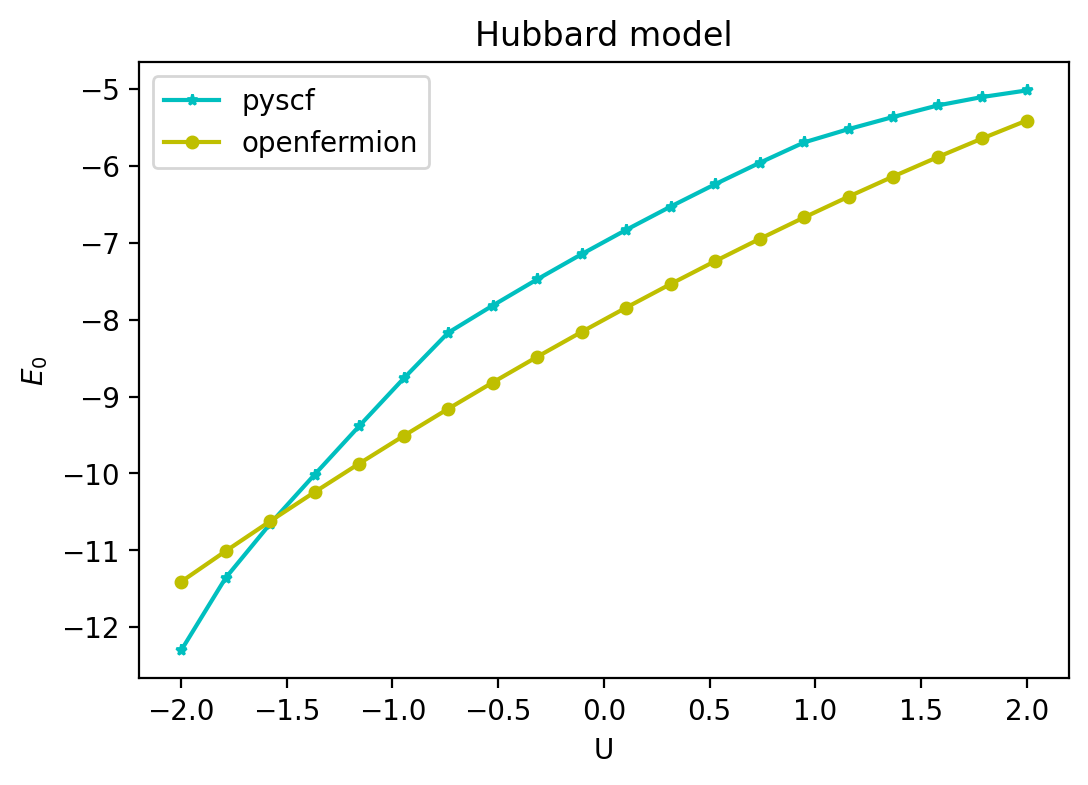

In [1]:
import copy
from itertools import product

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import numpy as np
from scipy import sparse
from scipy.linalg import expm

import openfermion as of
import fqe
from pyscf import gto, scf, ao2mo, cc, fci

"""Define the Hamiltonian."""
# Parameters.
# U = 2.0

u_list = np.linspace(-2.0, 2.0, 20)
e_list_pyscf = []
e_list_openfermion = []

def hubbard_openfermion(u):
    nsites = 6
    J = -1.0
    hubbard = of.fermi_hubbard(1, nsites, tunneling=-J, coulomb=u, periodic=False)
    sparse_hamiltonian = of.get_sparse_operator(hubbard)
    ground_energy, ground_state = of.get_ground_state(sparse_hamiltonian)
    # print('ground state: \n', ground_state)
    return ground_energy

def hubbard_pyscf(u):
    mol = gto.M(verbose=0)
    n = 6
    mol.nelectron = n
    # Setting incore_anyway=True to ensure the customized Hamiltonian (the _eri
    # attribute) to be used in the post-HF calculations.  Without this parameter,
    # some post-HF method (particularly in the MO integral transformation) may
    # ignore the customized Hamiltonian if memory is not enough.
    mol.incore_anyway = True

    h1 = np.zeros((n,n))
    for i in range(n-1):
        h1[i,i+1] = h1[i+1,i] = -1.0
    h1[n-1,0] = h1[0,n-1] = -1.0
    eri = np.zeros((n,n,n,n))
    for i in range(n):
        eri[i,i,i,i] = u

    mf = scf.RHF(mol);
    mf.get_hcore = lambda *args: h1
    mf.get_ovlp = lambda *args: np.eye(n)
    mf._eri = ao2mo.restore(8, eri, n)
    mf.kernel();


    # In PySCF, the customized Hamiltonian needs to be created once in mf object.
    # The Hamiltonian will be used everywhere whenever possible.  Here, the model
    # Hamiltonian is passed to CCSD object via the mf object.

    # mycc = cc.RCCSD(mf)
    # mycc.kernel()
    # e,v = mycc.ipccsd(nroots=3)
    # print(e)
    myfci = fci.FCI(mf);
    e_fci = myfci.kernel();

    return e_fci[0]


for u in u_list:
    e_list_pyscf.append(hubbard_openfermion(u))
    e_list_openfermion.append(hubbard_pyscf(u))

# print(e_list)
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(u_list, e_list_pyscf, 'c-*', markersize=4, label='pyscf')
ax.plot(u_list, e_list_openfermion, 'y-o', markersize=4, label='openfermion')
ax.set_xlabel('U')
ax.set_ylabel(r'$E_0$')
ax.set_title('Hubbard model')
ax.legend()